In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
import re
from textblob import TextBlob
from wordcloud import WordCloud

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string

## Get filtered data

In [4]:
data_company_twt = pd.read_csv('1.amazon_tweets_data.csv')
data_company_twt.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
1,550447850857828352,JorelLaraKalel,1420071969,Top 10 searched #stocks of #2014 $AAPL $FB $BA...,0,0,2
2,550453172096217088,jakubhajost,1420073237,RT @SeekingAlpha: A Look At BlackBerry's Deals...,0,0,0
3,550453624258965505,WSJ,1420073345,Jeff Bezos lost $7.4 billion in Amazon's worst...,21,139,57
4,550453897714995200,GillesKLEIN,1420073410,Jeff Bezos lost $7.4 billion in #Amazon worst ...,1,2,1


In [5]:
data_company_twt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718715 entries, 0 to 718714
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   tweet_id     718715 non-null  int64 
 1   writer       709192 non-null  object
 2   post_date    718715 non-null  int64 
 3   body         718715 non-null  object
 4   comment_num  718715 non-null  int64 
 5   retweet_num  718715 non-null  int64 
 6   like_num     718715 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 38.4+ MB


## Filter tweets by tag --> all tweets contains tsla tag

In [9]:
print(data_company_twt['body'][0])
print('--------------')
print('$amzn' not in data_company_twt['body'][0].lower())

S&P100 #Stocks Performance $HD $LOW $SBUX $TGT $DVN $IBM $AMZN $F $APA $GM $MS $HAL $DIS $MCD $BMY $XOM  more@ http://12Stocks.com/sp100
--------------
False


In [10]:
#list of tweets not contains $TSLA
to_delete = []
for i in data_company_twt.index:
    if ('$amzn' not in data_company_twt['body'][0].lower()):
        to_delete.append(i)

In [11]:
len(to_delete),to_delete

(0, [])

In [12]:
data_company_twt['body'][20]

'World’s 400 Richest People Add $92-B In 2014: World’s 400 Richest People Add $92-B In 2014 $AMZN, $BABA, $BX, ... http://tinyurl.com/ne9rgyc'

### prepare 'date' column

In [13]:
Dtime = []

timestamp = data_company_twt['post_date']
for i in data_company_twt.index:
    dt_object = datetime.fromtimestamp(data_company_twt['post_date'][i])
    Dtime.append(dt_object)
    
    #print("dt_object =", dt_object)
    #print("type(dt_object) =", type(dt_object))

data_company_twt['Dtime'] = Dtime
data_company_twt['Dtime']

0        2015-01-01 01:01:50
1        2015-01-01 01:26:09
2        2015-01-01 01:47:17
3        2015-01-01 01:49:05
4        2015-01-01 01:50:10
                 ...        
718710   2020-01-01 00:31:28
718711   2020-01-01 00:35:01
718712   2020-01-01 00:41:10
718713   2020-01-01 00:43:26
718714   2020-01-01 00:44:48
Name: Dtime, Length: 718715, dtype: datetime64[ns]

### prepare the date column, '%Y-%m-%d' format

In [14]:
dates = []

for i in data_company_twt.index:
    #dtime = str(data_company_twt['date'][i])
    dates.append(datetime.strftime(datetime.strptime(str(data_company_twt['Dtime'][i]),'%Y-%m-%d %H:%M:%S'), '%Y-%m-%d'))
    
data_company_twt['date'] = dates

In [15]:
data_company_twt

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,Dtime,date
0,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,2015-01-01 01:01:50,2015-01-01
1,550447850857828352,JorelLaraKalel,1420071969,Top 10 searched #stocks of #2014 $AAPL $FB $BA...,0,0,2,2015-01-01 01:26:09,2015-01-01
2,550453172096217088,jakubhajost,1420073237,RT @SeekingAlpha: A Look At BlackBerry's Deals...,0,0,0,2015-01-01 01:47:17,2015-01-01
3,550453624258965505,WSJ,1420073345,Jeff Bezos lost $7.4 billion in Amazon's worst...,21,139,57,2015-01-01 01:49:05,2015-01-01
4,550453897714995200,GillesKLEIN,1420073410,Jeff Bezos lost $7.4 billion in #Amazon worst ...,1,2,1,2015-01-01 01:50:10,2015-01-01
...,...,...,...,...,...,...,...,...,...
718710,1212154334600818689,thequ4nt,1577835088,"[Yahoo Finance Video - December 31, 2019] $AMZ...",0,1,1,2020-01-01 00:31:28,2020-01-01
718711,1212155226377117697,DentonBlackwell,1577835301,@Ryzenn $AAPL has to have a lights out ER to k...,0,0,1,2020-01-01 00:35:01,2020-01-01
718712,1212156775178416128,ITRADEVOL,1577835670,Is there a public database or website where I ...,0,0,2,2020-01-01 00:41:10,2020-01-01
718713,1212157343351238656,naashonomics,1577835806,$FB $AMZN $GOOGL $NFLX #FANG 2019,0,0,0,2020-01-01 00:43:26,2020-01-01


## sentiment analysis using textblob

In [16]:
def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

# df["cleaned_tweet"].unique()

In [17]:
#clean tweets
def cleanTwt(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #remove mentions
    text = re.sub(r'[0-9]+', '', text) #remove numbers
    text = re.sub(r'\[', '', text) #remove [ symbole
    text = re.sub(r'\]', '', text) #remove ] symbole
    text = re.sub(r'\n', '', text) #remove \n 
    text = re.sub(r'/', '', text) #remove / symbole
    text = re.sub(r'#', '', text) #remove # symbole
    #text = re.sub(r'RT[\s]+', '', text) # retweet RT
    text = re.sub(r'http?:\/\/S+', '', text) #remove the hyper link
    
    return text

In [18]:
stopwords_set = set(stopwords.words("english"))
nltk.download('stopwords')
punctuations = string.punctuation
nltk.download('punkt')

def preprocess_tweet_text(tweet):
    tweet = tweet.lower()
    tweet = remove_html(tweet)
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    #tweet= tweet.replace("[^a-zA-Z0–9]", " ")
    # Tokenization
    tweet_tokens = word_tokenize(tweet)
    # Remove stopwords
    filtered_words = [w for w in tweet_tokens if w not in stopwords_set and w not in punctuations]
    

    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mariame\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mariame\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
data_company_twt['cleaned_text'] = data_company_twt['body'].apply(preprocess_tweet_text)
data_company_twt['cleaned_text'] = data_company_twt['cleaned_text'].apply(cleanTwt)

### word cloud

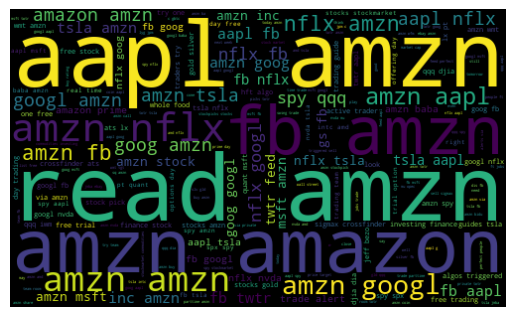

In [20]:
allWords = ' '.join( [twts for twts in data_company_twt['cleaned_text']])
wordCloud = WordCloud(width = 500, height =300, random_state = 21 ,max_font_size = 119).generate(allWords)

plt.imshow(wordCloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### calculate sentiment score

In [21]:
def getSujectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    
    return TextBlob(text).sentiment.polarity

data_company_twt['Subjuctivity'] = data_company_twt['cleaned_text'].apply(getSujectivity)
data_company_twt['Polarity'] = data_company_twt['cleaned_text'].apply(getPolarity)

### create the sentiment classes and one hot encoding

In [22]:
def getAnalysis(score):
    if score < 0:
        return 'negative'
    elif(score == 0):
        return 'neutral'
    else:
        return 'positive'
    
data_company_twt['Class_sentiment'] = data_company_twt['Polarity'].apply(getAnalysis)

In [23]:
data_company_twt.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,Dtime,date,cleaned_text,Subjuctivity,Polarity,Class_sentiment
0,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,2015-01-01 01:01:50,2015-01-01,sp stocks performance hd low sbux tgt dvn ibm ...,0.3,0.0,neutral
1,550447850857828352,JorelLaraKalel,1420071969,Top 10 searched #stocks of #2014 $AAPL $FB $BA...,0,0,2,2015-01-01 01:26:09,2015-01-01,top searched stocks aapl fb baba tsla bac go...,0.5,0.5,positive
2,550453172096217088,jakubhajost,1420073237,RT @SeekingAlpha: A Look At BlackBerry's Deals...,0,0,0,2015-01-01 01:47:17,2015-01-01,rt look blackberrys deals acquisitions amzn bbry,0.0,0.0,neutral
3,550453624258965505,WSJ,1420073345,Jeff Bezos lost $7.4 billion in Amazon's worst...,21,139,57,2015-01-01 01:49:05,2015-01-01,jeff bezos lost billion amazons worst year si...,1.0,-1.0,negative
4,550453897714995200,GillesKLEIN,1420073410,Jeff Bezos lost $7.4 billion in #Amazon worst ...,1,2,1,2015-01-01 01:50:10,2015-01-01,jeff bezos lost billion amazon worst year sin...,1.0,-1.0,negative


In [24]:
data_company_twt_sentim = pd.get_dummies(data_company_twt, columns = ['Class_sentiment'])
data_company_twt_sentim

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,Dtime,date,cleaned_text,Subjuctivity,Polarity,Class_sentiment_negative,Class_sentiment_neutral,Class_sentiment_positive
0,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,2015-01-01 01:01:50,2015-01-01,sp stocks performance hd low sbux tgt dvn ibm ...,0.300000,0.000000,0,1,0
1,550447850857828352,JorelLaraKalel,1420071969,Top 10 searched #stocks of #2014 $AAPL $FB $BA...,0,0,2,2015-01-01 01:26:09,2015-01-01,top searched stocks aapl fb baba tsla bac go...,0.500000,0.500000,0,0,1
2,550453172096217088,jakubhajost,1420073237,RT @SeekingAlpha: A Look At BlackBerry's Deals...,0,0,0,2015-01-01 01:47:17,2015-01-01,rt look blackberrys deals acquisitions amzn bbry,0.000000,0.000000,0,1,0
3,550453624258965505,WSJ,1420073345,Jeff Bezos lost $7.4 billion in Amazon's worst...,21,139,57,2015-01-01 01:49:05,2015-01-01,jeff bezos lost billion amazons worst year si...,1.000000,-1.000000,1,0,0
4,550453897714995200,GillesKLEIN,1420073410,Jeff Bezos lost $7.4 billion in #Amazon worst ...,1,2,1,2015-01-01 01:50:10,2015-01-01,jeff bezos lost billion amazon worst year sin...,1.000000,-1.000000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718710,1212154334600818689,thequ4nt,1577835088,"[Yahoo Finance Video - December 31, 2019] $AMZ...",0,1,1,2020-01-01 00:31:28,2020-01-01,yahoo finance video december amzn znga amazo...,0.500000,0.500000,0,0,1
718711,1212155226377117697,DentonBlackwell,1577835301,@Ryzenn $AAPL has to have a lights out ER to k...,0,0,1,2020-01-01 00:35:01,2020-01-01,aapl lights er keep current levels retrace co...,0.450000,0.100000,0,0,1
718712,1212156775178416128,ITRADEVOL,1577835670,Is there a public database or website where I ...,0,0,2,2020-01-01 00:41:10,2020-01-01,public database website query stocks like amzn...,0.403175,0.142857,0,0,1
718713,1212157343351238656,naashonomics,1577835806,$FB $AMZN $GOOGL $NFLX #FANG 2019,0,0,0,2020-01-01 00:43:26,2020-01-01,fb amzn googl nflx fang,0.000000,0.000000,0,1,0


In [25]:
data_company_twt_sentim.to_csv(r'2.amazon_data_dates_sentiment_analysis.csv', index=False)